# Training a gender classification model on Samrómur data

### Load data

In [1]:
import librosa
from ipywidgets import IntProgress
import pandas as pd
from sklearn.neural_network import MLPClassifier # multi-layer perceptron model
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay # to measure how good the model is
from sklearn import preprocessing
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("data/sample_samromur_21.05/metadata.tsv", sep="\t", dtype="string")

In [3]:
def extract_features(dataset, dir, mean=False):
    """
    Extracts MFCCs from the audio files in the dataset.
    Takes the mean of the MFCCs over time if mean=True (1D array), otherwise returns MFCCs for each frame (2D array).
    Returns a list of MFCCs and a list of labels.
    """
    X = []
    X_mean = []
    y = []
    progress = IntProgress(value=0, max=len(dataset), description="{} / {}".format(0, len(dataset)))
    display(progress)
    for index, row in dataset.iterrows():
        filepath = row["status"] + "/" + row["speaker_id"] + "/" + row["filename"]
        signal, sr = librosa.load(dir + "/" + filepath)
        mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=13)
        #mfcc_deltas = librosa.feature.delta(mfccs) # delta features
        #mfcc_deltas2 = librosa.feature.delta(mfccs, order=2) # delta-delta features
        #X.append(np.concatenate((mfccs.mean(axis=1), mfcc_deltas.mean(axis=1), mfcc_deltas2.mean(axis=1)))) # averaging the features over the file and concatenating them
        if mfccs.shape[1] > 250:
            # only using the first 250 windows
            mfccs_subset = mfccs[:, 0:250]
        else:
            # if too short, add zero padding to mfccs_subset until you get 250 windows
            mfccs_subset = np.pad(mfccs, ((0, 0), (0, 250 - mfccs.shape[1])), 'constant', constant_values=0)
        # flatten the 2d array mfccs_subset to 1d
        mfccs_subset = mfccs_subset.flatten()
        # also trying just averaging the mfccs over time
        mfccs_mean = mfccs.mean(axis=1)
        X_mean.append(mfccs_mean)
        X.append(mfccs_subset)
        y.append(row["gender"])
        progress.value += 1
        progress.description = "{} / {}".format(progress.value, len(dataset))
    return X, X_mean, y

In [4]:
# Extract features from the first 1000 training files and the first 100 test files
# This will take a while
samromur_dir = "data/sample_samromur_21.05"
X_train, X_train_mean, y_train = extract_features(data[data["status"]=="train"].head(2000), samromur_dir, mean=True)
X_test, X_test_mean, y_test = extract_features(data[data["status"]=="test"].head(100), samromur_dir, mean=True)

IntProgress(value=0, description='0 / 2000', max=2000)

IntProgress(value=0, description='0 / 100')

### Training model with MFCCs from the first 250 windows of audio

In [5]:
# MLPClassifier (Multi-layer Perceptron) is a simple feed-forward network
classifier = MLPClassifier(random_state=5) # random state just ensures that the training will produce the same model each time
classifier.fit(X_train, y_train) # train the model

MLPClassifier(random_state=5)

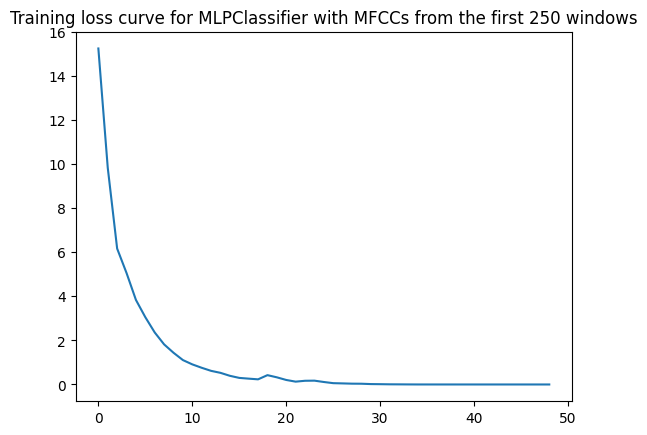

In [6]:
plt.plot(classifier.loss_curve_)
plt.title("Training loss curve for MLPClassifier with MFCCs from the first 250 windows")
plt.show()

In [7]:
# Predict the gender of the test files
y_test_pred = classifier.predict(X_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

      female       0.58      0.85      0.69        26
        male       0.94      0.78      0.85        74

    accuracy                           0.80       100
   macro avg       0.76      0.81      0.77       100
weighted avg       0.84      0.80      0.81       100



Confusion Matrix for MLPClassifier with MFCCs from the first 250 windows


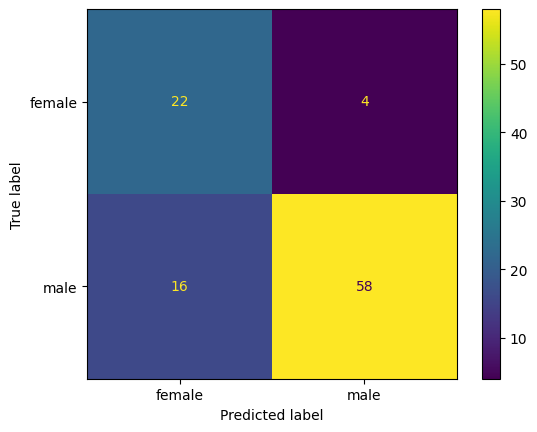

In [8]:
# Plot the confusion matrix
cm = confusion_matrix(y_test, y_test_pred, labels=classifier.classes_)
disp = ConfusionMatrixDisplay(cm, display_labels=classifier.classes_)
print("Confusion Matrix for MLPClassifier with MFCCs from the first 250 windows")
disp.plot()

### Training model with the mean of the MFCCs over the time of the whole audio file

In [9]:
# MLPClassifier (Multi-layer Perceptron) is a simple feed-forward network
classifier_mean = MLPClassifier(random_state=5) # random state just ensures that the training will produce the same model each time
classifier_mean.fit(X_train_mean, y_train) # train the model

MLPClassifier(random_state=5)

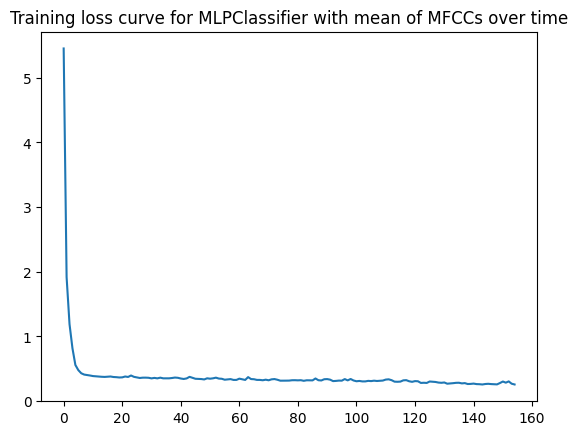

In [10]:
plt.title("Training loss curve for MLPClassifier with mean of MFCCs over time")
plt.plot(classifier_mean.loss_curve_)
plt.show()

In [11]:
# Predict the gender of the test files
y_test_pred_mean = classifier_mean.predict(X_test_mean)
print(classification_report(y_test, y_test_pred_mean))

              precision    recall  f1-score   support

      female       0.59      0.77      0.67        26
        male       0.91      0.81      0.86        74

    accuracy                           0.80       100
   macro avg       0.75      0.79      0.76       100
weighted avg       0.83      0.80      0.81       100



Confusion Matrix for MLPClassifier with mean MFCCs over time


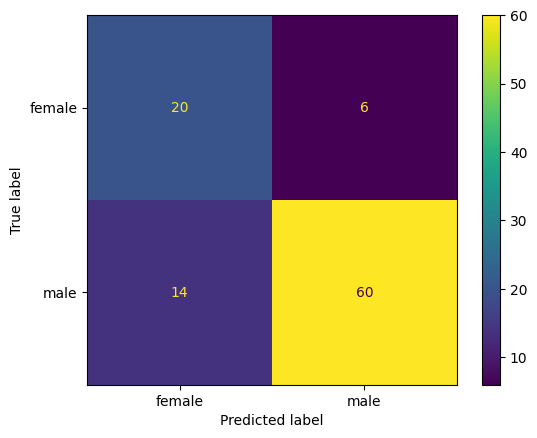

In [12]:
# Plot the confusion matrix
cm_mean = confusion_matrix(y_test, y_test_pred_mean, labels=classifier.classes_)
disp = ConfusionMatrixDisplay(cm_mean, display_labels=classifier_mean.classes_)
print("Confusion Matrix for MLPClassifier with mean MFCCs over time")
disp.plot()

A very important part of your project will be that you can correctly describe how your features are extracted and what information they contain. Please don't forget it.

### Ideas for your own project:

- Make another classifier using the Samrómur dataset (e.g. age, dialect, native language, or speaker identity)
    - Note for speaker identity you will probably need to download the full dataset to get many training samples for each speaker
- Make another classifier using a different dataset (e.g. emotion recognition, speaker recognition, language recognition)
- Make a music genre or instrument classifier using music files
- Try to improve the model by adding more features that you have learned about in the course
- Rather than averaging MFCCs across the file, train an RNN that takes the MFCCs for each frame as input